# A brief summary of a Cyclic Generative Adversarial Network

Paper referred: https://arxiv.org/pdf/1703.10593.pdf

This notebook will give us a brief introduction of the above network. This network uses unpaired data for the purposes of training. It uses the **cycle consistency loss** to enable training without a one-to-one mapping between source and the target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All we need is the source and the target dataset (which is directoy of images).

## Description of models:

A total of 2 Generative models and 2 Discriminator models will work in unison to make this network. 
They will utilise different loss functions for training.

**Since there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training**. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The loss functions an their respective descriptions are stated below.

The discriminator loss and the generator loss are as follows:

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# constant to signify the importance of how important the cyclic loss should be in the iterations
LAMBDA = 10

# instance of BinaryCrossentropy class
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Example of Binary cross entropy

https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

In [3]:
y_true = [0, 1, 0, 0]
y_pred = [-190., 1000., -200., -300.]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()

0.0

### discriminator loss

In [4]:
# discriminator loss
def discriminator_loss(real,generated):
    '''
    Function description:
    real = the output of discriminator when real image is fed in
    generated = the output of discriminator when fake image is fed in
    
    Discriminator loss will determine whether it is able to detect real from real and fake/generated from fake/generated.
    '''
    real_loss = loss_obj(tf.ones_like(real),real)
    
    # generated image loss
    generated_loss = loss_obj(tf.zeros_like(generated),generated)
    
    # add them
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

### generator loss

input: The output of the discriminator when its fed a fake/generated image.

Ideally the discriminator should be tricked by the generator into thinking that the generated images are real images.

In [5]:
# generator loss
def generator_loss(generated):
    '''
    input: output of a discriminator when supplied a generated/fake image
    
        It implies that this loss gets smaller if the discriminator marks the generated image as the real image.
        In other words this loss helps to fool the discriminator into thinking that the generated image is the real image,
        by making the generator improve by each epoch.
    '''
    return loss_obj(tf.ones_like(generated),generated)

These functions are implemented for each training epoch. 

# Input the data:

The data is taken from https://www.kaggle.com/datasets/suyashdamle/cyclegan

In [6]:
import os


In [7]:
train_aerial_path = './maps/maps/trainA'
train_maps_path = './maps/maps/trainB'
# Number of train images
print(len(os.listdir(train_aerial_path)))
print(len(os.listdir(train_maps_path)))



1096
1096


In [8]:
test_aerial_path = './maps/maps/testA'
test_maps_path = './maps/maps/testB'

print(len(os.listdir(test_aerial_path)))
print(len(os.listdir(test_maps_path)))

1098
1098


Checking the shape of the images

In [9]:
plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])).shape

(128, 128, 3)

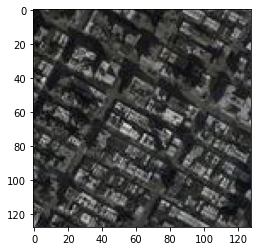

In [10]:
plt.imshow(plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])))

Reducing the size of the images from 600x600 to 128x128 because of GPU limit

In [11]:
from PIL import Image

In [12]:
# images_path = './Final project/maps/maps/testB'
# size = 128, 128 # (horizontal pixels, vertical pixels)
# for image_name, num in zip(os.listdir(images_path), range(len(os.listdir(images_path)))):
#         full_path = os.path.join(images_path, image_name)
#         # changing resolution
#         img = Image.open(full_path)
#         resized_img = img.resize(size, Image.ANTIALIAS)
#         os.remove(images_path + '/' +image_name)
#         resized_img.save(images_path + '/'+str(num) + '.jpg')

In [13]:
plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])).shape

(128, 128, 3)

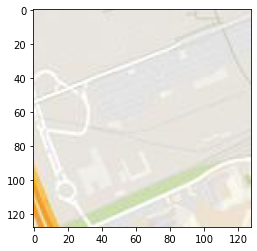

In [14]:
plt.imshow(plt.imread(os.path.join(train_maps_path,os.listdir(train_maps_path)[0])))

In [15]:
train_aerial = []
train_maps = []

# For aerial images
for image_name in os.listdir(train_aerial_path):
    full_img_name = os.path.join(train_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(train_maps_path):
    full_img_name = os.path.join(train_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)

# we can also take few images from test folder for training purposes

In [16]:
# For aerial images
for image_name in os.listdir(test_aerial_path)[:500]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[500:1000]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)

In [17]:
train_aerial = np.array(train_aerial, dtype='float32')
train_maps = np.array(train_maps, dtype = 'float32')
print(train_aerial.shape)
print(train_maps.shape)

(1596, 128, 128, 3)
(1596, 128, 128, 3)


Similarly for test images

In [18]:
test_aerial = []
test_maps = []

# For aerial images
for image_name in os.listdir(test_aerial_path)[500:1000]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[:500]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_maps.append(img_arr/255)

test_aerial = np.array(test_aerial, dtype='float32')
test_maps = np.array(test_maps, dtype = 'float32')
print(test_aerial.shape)
print(test_maps.shape)

(500, 128, 128, 3)
(500, 128, 128, 3)


Dimensions of the images:

In [19]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 3


'''Convert array into tensorFlow pipeline to easily import the data in the model'''
train_aerials = tf.data.Dataset.from_tensor_slices(train_aerial).batch(1)
train_maps = tf.data.Dataset.from_tensor_slices(train_maps).batch(1)


# Building the model:

The model consists of Instance normalization:

Reference:
https://becominghuman.ai/all-about-normalization-6ea79e70894b

### Batch Normalization
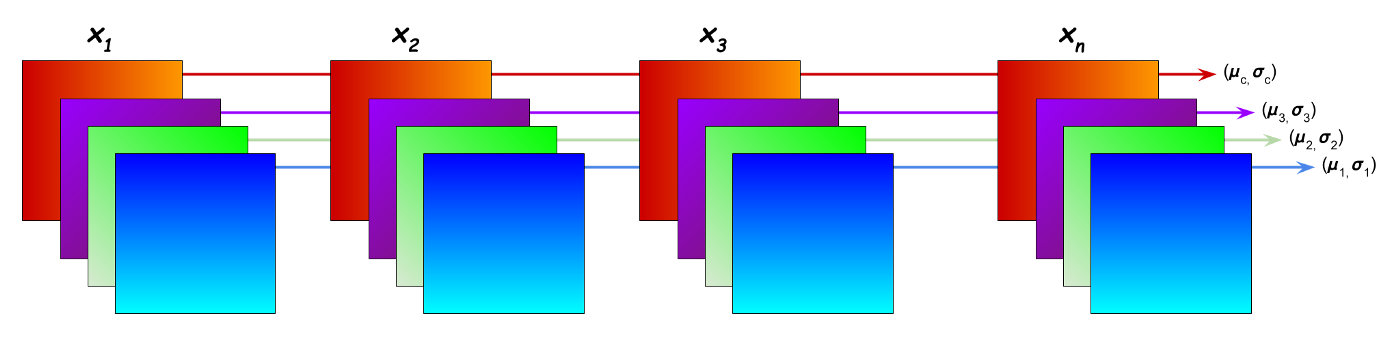

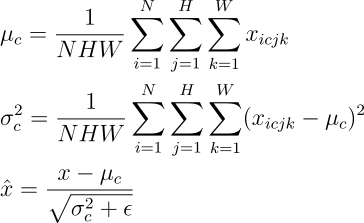

In “**Batch Normalization**”, mean and variance are calculated for each individual channel across all samples and both spatial dimensions.

### Instance Normalization
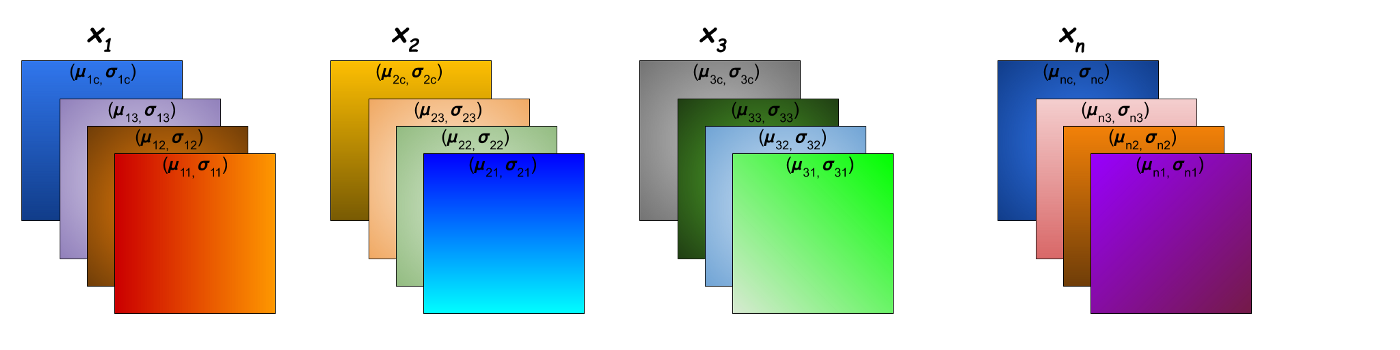

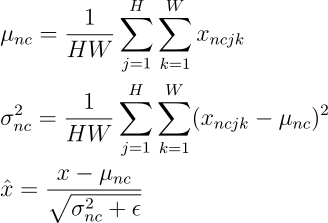

In “**Instance Normalization**”, mean and variance are calculated for each individual channel for each individual sample across both spatial dimensions.

### Layer Normalization
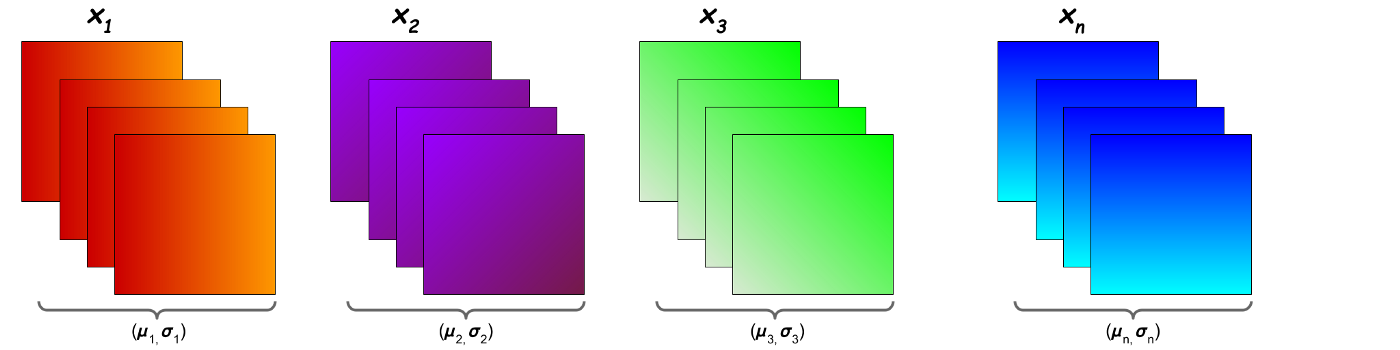

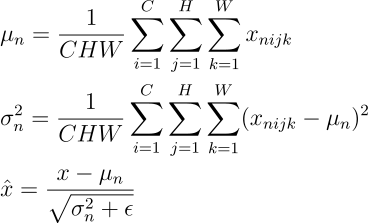

In “**Layer Normalization**”, mean and variance are calculated for each individual sample across all channels and both spatial dimensions.

Reference:
https://becominghuman.ai/all-about-normalization-6ea79e70894b


## In short:

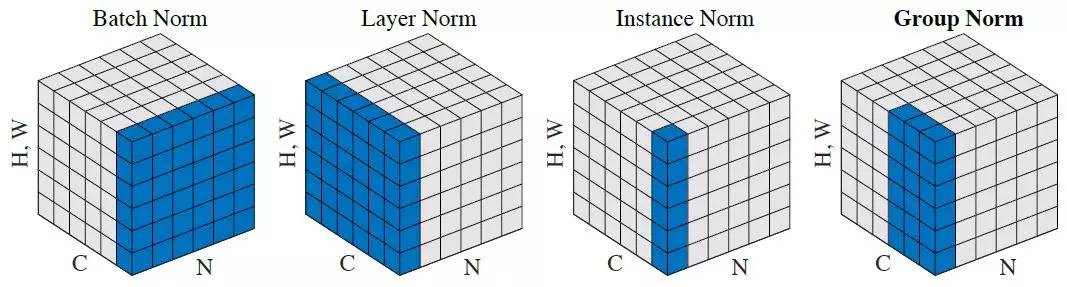

N = batch size <br>
C = Color channels <br>
W = Width of image <br>
H = Height of image <br>

https://github.com/DmitryUlyanov/texture_nets/blob/master/InstanceNormalization.lua
https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/layers/normalization/instancenormalization.py

In [20]:
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as  K

In [21]:
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [22]:
### Resnet block
def resnet_block(inp_layer,filters):
    c1 = Conv2D(filters=filters, kernel_size=3, strides=1,padding='same')(inp_layer)
    c1 = InstanceNormalization(axis=-1)(c1)
    c1 = Activation('relu')(c1)

    c2 = Conv2D(filters=filters, kernel_size=3, strides=1,padding='same')(c1)
    c2 = InstanceNormalization(axis=-1)(c2)
    c2 = concatenate([c2,inp_layer])
    return c2

## Discriminator and Generator model:

The idea of creating a U-resnet generator is from:
https://www.researchgate.net/publication/333238725_Retinal_image_synthesis_from_multiple-landmarks_input_with_generative_adversarial_networks

In [23]:
from tensorflow.keras.initializers import RandomNormal

In [112]:
def Generator():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    input_layer = Input(shape=[128,128,3])

    c = Conv2D(filters=64, kernel_size=7,padding='same', kernel_initializer=init)(input_layer) #(bs, 128, 128, 64)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)

    c = Conv2D(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(c)
    ac = Activation('relu')(inst_norm)

    c = Conv2D(256, (3,3),strides=(2,2),padding='same',kernel_initializer=init)(ac)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)

    #Resnet
    for i in range(6):
        c = resnet_block(c,256)

    ct = Conv2DTranspose(128, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    ct = Conv2DTranspose(64, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    last = Conv2DTranspose(filters=3,kernel_size=(7,7), padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(last)
    c = Activation('tanh')(inst_norm)

    return tf.keras.models.Model(inputs = input_layer,outputs=c)


###########################################
# def Discriminator():
#     init - RandomNormal(stddev=0.02)
#     input_layer = Input(shape=[128,128,3])
#     # downsampling
#     conv1 = Conv2D(filters=64, kernel_size=7,padding='same', kernel_initializer=init)(input_layer) # (bs, 64, 64, 64)
#     a = Activation('relu')(conv1)

#     conv2 = Conv2D(filters=128,kernel_size=3, strides=2,kernel_initializer=init,padding='same')(a) #(bs, 32, 32, 128)
#     inst_norm = InstanceNormalization(axis=-1)(conv2)
#     a = Activation('relu')(inst_norm)

#     conv3 = Conv2D(filters=256,kernel_size=3, strides=2,kernel_initializer=init,padding='same')(a) #(bs, 16, 16, 256)
#     inst_norm = InstanceNormalization(axis=-1)(conv3)
#     a = Activation('relu')(inst_norm)

#     for _ in range(9):
#         a = resnet_block(a,256)
    
#     a = Conv2DTranspose(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     a = Activation('relu')(a)

#     a = Conv2DTranspose(64,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     a = Activation('relu')(a)

#     a = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     last = Activation('tanh')(a)
#     return tf.keras.Model(inputs=input_layer, outputs=last)
def Discriminator():
    input_layer = Input(shape=[128,128,3])
    # downsampling
    conv1 = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',activation='relu')(input_layer) # (bs, 64, 64, 64)
    leaky1 = LeakyReLU()(conv1)

    conv2 = Conv2D(filters=128,kernel_size=4, strides=2,activation='relu',padding='same')(leaky1) #(bs, 32, 32, 128)
    bat_norm = InstanceNormalization(axis=-1)(conv2)
    leaky2 = LeakyReLU()(bat_norm)

    conv3 = Conv2D(filters=256,kernel_size=4, strides=2,activation='relu',padding='same')(leaky2) #(bs, 16, 16, 256)
    bat_norm = InstanceNormalization(axis=-1)(conv3)
    leaky3 = LeakyReLU()(bat_norm)

    zero_pad1 = ZeroPadding2D()(leaky3)
    conv = Conv2D(filters=512, kernel_size=4, strides=1, use_bias=False)(zero_pad1)

    batch_norm = InstanceNormalization(axis=-1)(conv)

    leaky_relu = LeakyReLU()(batch_norm)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    last = Conv2D(1, 4, strides=1)(zero_pad2)

    return tf.keras.Model(inputs=input_layer, outputs=last)

We will have a look at cyclic loss and identity losses since we have already covered other losses

In [113]:
def calc_cycle_loss(real_image, cycle_image):
    loss1 = tf.reduce_mean(tf.abs(real_image-cycle_image))
    return LAMBDA*loss1

''' generator_g is responsible for translating image X to image Y. Identity
loss says that, if you fed image Y to generator G, it should yield the real
image Y or something close to image Y.
    identity_loss = |G(Y)-Y|+|F(X)-X|'''
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    print(loss)
    return LAMBDA*0.5*loss

## Building generator and discriminator

In [114]:
#########################################
#########################################
# Building generators and discriminators
generator_g = Generator() # will convert aerial images to maps
generator_f = Generator() # will convert maps to aerial images

discriminator_x = Discriminator() # checks if generated maps are fakes or real.
discriminator_y = Discriminator() # checks if generated aerial images are fakes or real. 

In [116]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)


        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))


    
def generate_img(model, inp):
    op = model(inp).numpy()*0.5+0.5 #setting values from (-1,1) to (0,1)

    display_list = [inp[0], op[0]]
    title = ['input','generated']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [117]:
from IPython.display import clear_output

In [118]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)




EPOCHS = 300


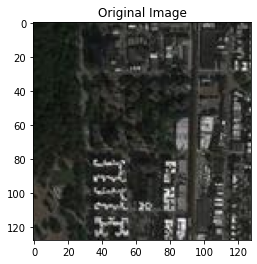

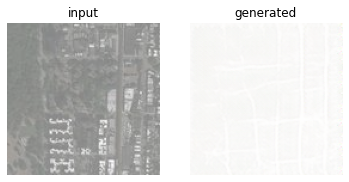

Model saved
Time taken for epoch 40 is 773.2069697380066
.......................................................................................

KeyboardInterrupt: 

In [119]:

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for en_image_x, en_image_y in tf.data.Dataset.zip((train_aerials, train_maps)):

        train_step(en_image_x, en_image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)

    #Random image:
    rnd = np.random.randint(0, len(train_aerial))
    random_img = train_aerial[rnd]
    plt.imshow(random_img)
    plt.title('Original Image')
    plt.show()
    generate_img(generator_g,random_img.reshape((1,)+random_img.shape[:]))
    if (epoch + 1) % 5 == 0:
        # save the model:
        generator_g.save('generator_g_better2.h5',overwrite=True)
        generator_f.save('generator_f_better2.h5',overwrite=True)
        discriminator_x.save('discriminator_x_better2.h5',overwrite=True)
        discriminator_y.save('discriminator_y_better2.h5',overwrite=True)
        print('Model saved')

    print(f'Time taken for epoch {epoch + 1} is {time.time() - start}')


In [60]:
type(0)

int

In [59]:
type(InstanceNormalization)

type

In [58]:
discriminator_x.save('discriminator_x.h5',overwrite=True)

In [128]:
# recalling the models

generator_g = tf.keras.models.load_model('generator_g_better2.h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})
generator_f = tf.keras.models.load_model('generator_f_better.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

discriminator_x = tf.keras.models.load_model('discriminator_x_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
discriminator_y = tf.keras.models.load_model('discriminator_y_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

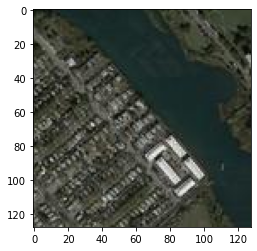

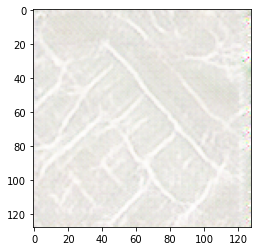

In [129]:
img1 = 337
plt.imshow(test_aerial[img1].reshape(1,128,128,3)[0])
plt.show()
plt.imshow(generator_g(test_aerial[img1].reshape(1,128,128,3))[0])
plt.show()

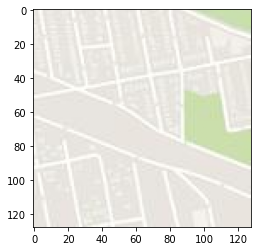

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


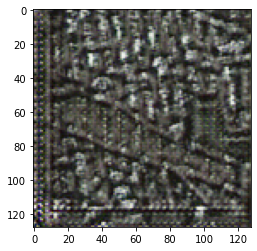

In [135]:
img2 = 112
plt.imshow(test_maps[img2].reshape(1,128,128,3)[0])
plt.show()
plt.imshow(generator_f(test_maps[img2].reshape(1,128,128,3))[0])
plt.show()

In [ ]:
def aerial_to_maps(aerial_image):
    """
    Converts aerial images to map images.
    """
    result = generator_g(aerial_to_maps)
    